Epoch 1/10, Loss: 0.6221, Val Loss: 0.5312, Train Acc: 74.17%, Val Acc: 77.06%
Epoch 2/10, Loss: 0.4914, Val Loss: 0.4634, Train Acc: 79.04%, Val Acc: 80.41%
Epoch 3/10, Loss: 0.4422, Val Loss: 0.4299, Train Acc: 81.43%, Val Acc: 82.10%
Epoch 4/10, Loss: 0.4083, Val Loss: 0.3999, Train Acc: 82.95%, Val Acc: 83.57%
Epoch 5/10, Loss: 0.3815, Val Loss: 0.3782, Train Acc: 84.23%, Val Acc: 84.17%
Epoch 6/10, Loss: 0.3611, Val Loss: 0.3536, Train Acc: 85.18%, Val Acc: 85.53%
Epoch 7/10, Loss: 0.3438, Val Loss: 0.3469, Train Acc: 85.93%, Val Acc: 85.94%
Epoch 8/10, Loss: 0.3284, Val Loss: 0.3325, Train Acc: 86.67%, Val Acc: 86.34%
Epoch 9/10, Loss: 0.3144, Val Loss: 0.3202, Train Acc: 87.22%, Val Acc: 86.96%
Epoch 10/10, Loss: 0.3038, Val Loss: 0.3079, Train Acc: 87.67%, Val Acc: 87.42%

Final Evaluation:
Accuracy  = 87.42%
Precision = 85.59%
Recall    = 74.89%
F1 Score  = 78.87%
AUC Score = 98.67%


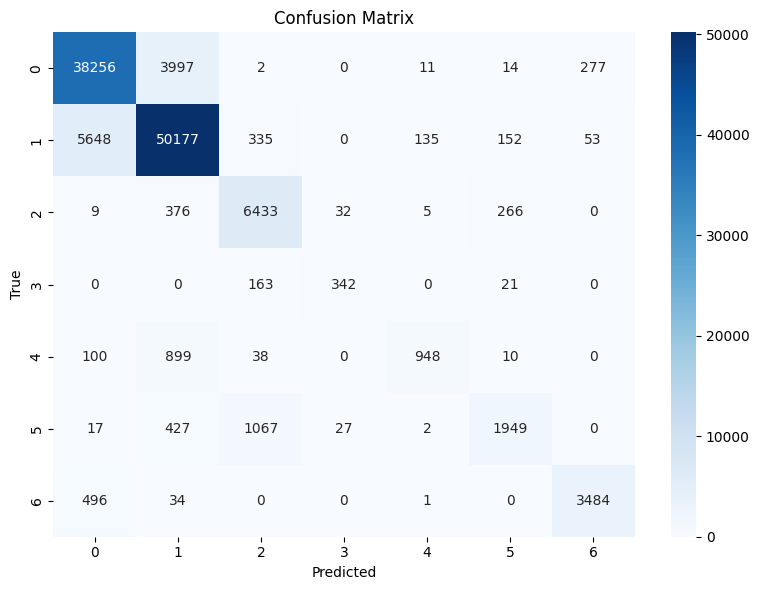

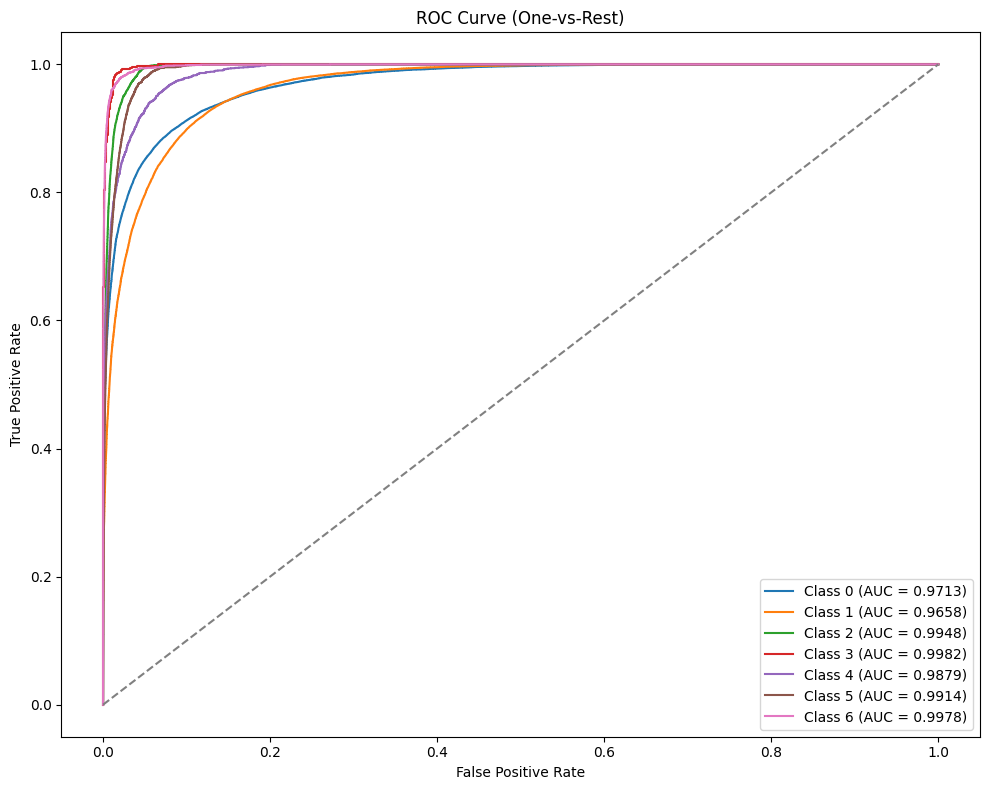

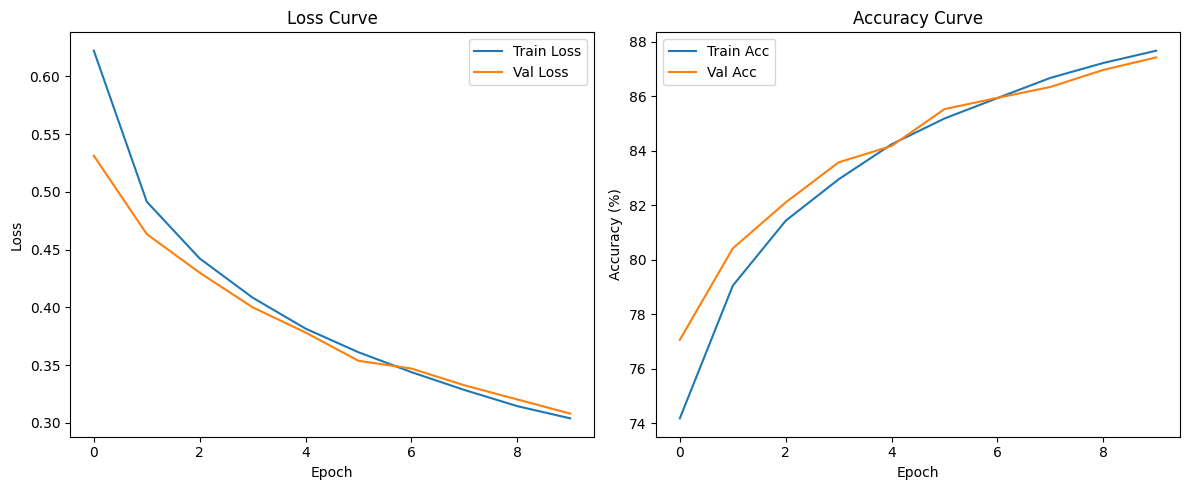

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
data = pd.read_csv(r'compressed_data.csv.gz')
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type'] - 1  # Make it zero-indexed

# Preprocessing
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc4 = nn.Linear(hidden_size // 4, output_size)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_size = X_train.shape[1]
hidden_size = 1024
output_size = len(y.unique())
model_pt = Net(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.0001)

# Training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 10

for epoch in range(epochs):
    model_pt.train()
    total_loss = 0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    model_pt.eval()
    val_loss = 0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_pt(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

# Final Evaluation
model_pt.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_pt(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_prob.extend(probs.tolist())

y_true_binarized = LabelBinarizer().fit_transform(y_true)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true_binarized, y_prob, multi_class='ovr')

print("\nFinal Evaluation:")
print(f"Accuracy  = {accuracy*100:.2f}%")
print(f"Precision = {precision*100:.2f}%")
print(f"Recall    = {recall*100:.2f}%")
print(f"F1 Score  = {f1*100:.2f}%")
print(f"AUC Score = {auc*100:.2f}%")

# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(output_size), yticklabels=range(output_size))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (One vs Rest)
plt.figure(figsize=(10, 8))
for i in range(output_size):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
    auc_score = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\muham\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10, Loss: 0.6870, Val Loss: 0.5551, Train Acc: 72.66%, Val Acc: 76.57%
Epoch 2/10, Loss: 0.5166, Val Loss: 0.4887, Train Acc: 78.00%, Val Acc: 79.36%
Epoch 3/10, Loss: 0.4640, Val Loss: 0.4510, Train Acc: 80.41%, Val Acc: 80.86%
Epoch 4/10, Loss: 0.4265, Val Loss: 0.4141, Train Acc: 82.21%, Val Acc: 82.71%
Epoch 5/10, Loss: 0.3983, Val Loss: 0.3906, Train Acc: 83.50%, Val Acc: 84.06%
Epoch 6/10, Loss: 0.3765, Val Loss: 0.3785, Train Acc: 84.54%, Val Acc: 84.47%
Epoch 7/10, Loss: 0.3574, Val Loss: 0.3555, Train Acc: 85.44%, Val Acc: 85.59%
Epoch 8/10, Loss: 0.3421, Val Loss: 0.3450, Train Acc: 86.12%, Val Acc: 86.18%
Epoch 9/10, Loss: 0.3281, Val Loss: 0.3263, Train Acc: 86.79%, Val Acc: 87.11%
Epoch 10/10, Loss: 0.3156, Val Loss: 0.3168, Train Acc: 87.34%, Val Acc: 87.49%

Final Evaluation:
Accuracy  = 87.49%
Precision = 82.27%
Recall    = 74.36%
F1 Score  = 77.45%
AUC-ROC   = 98.53%


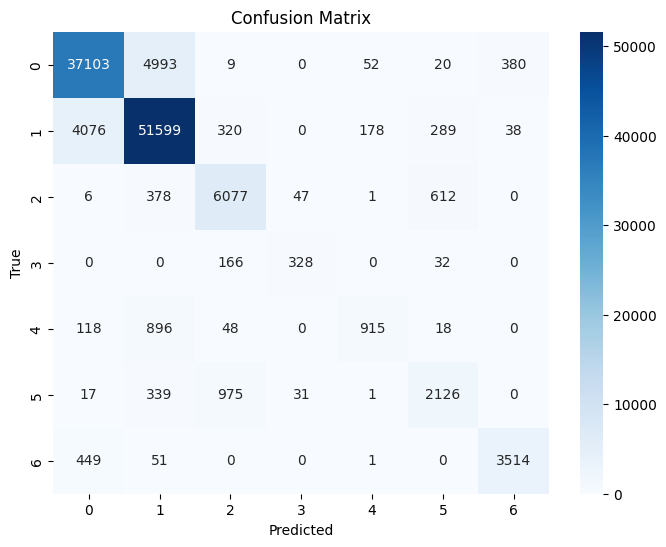

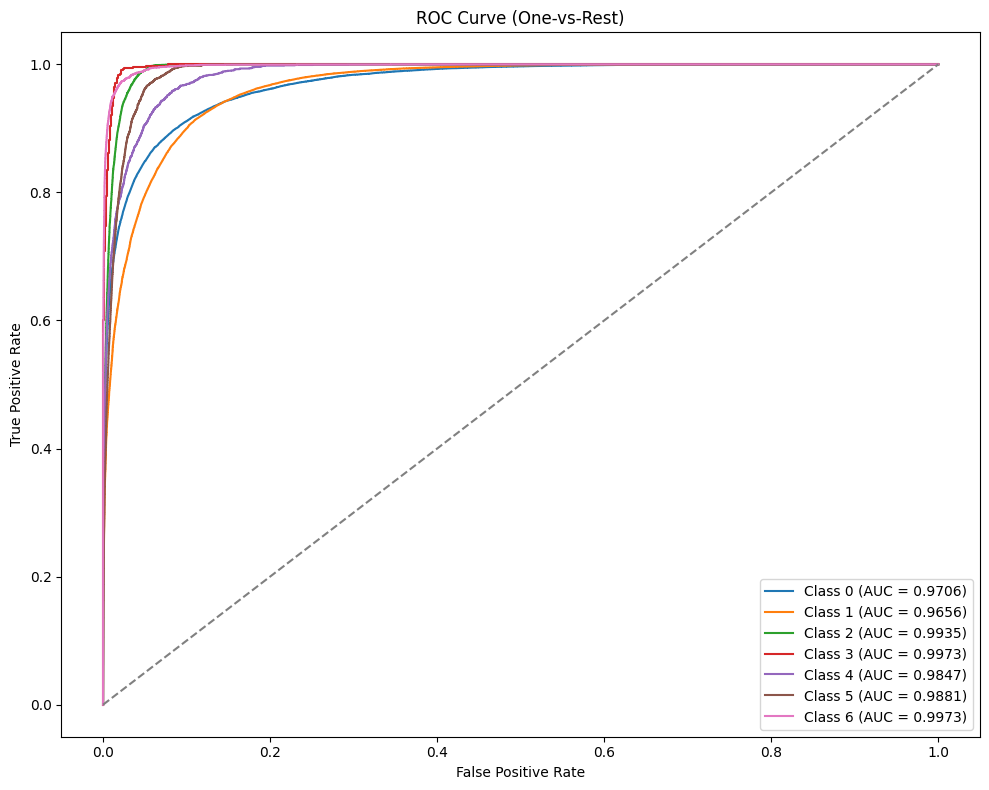

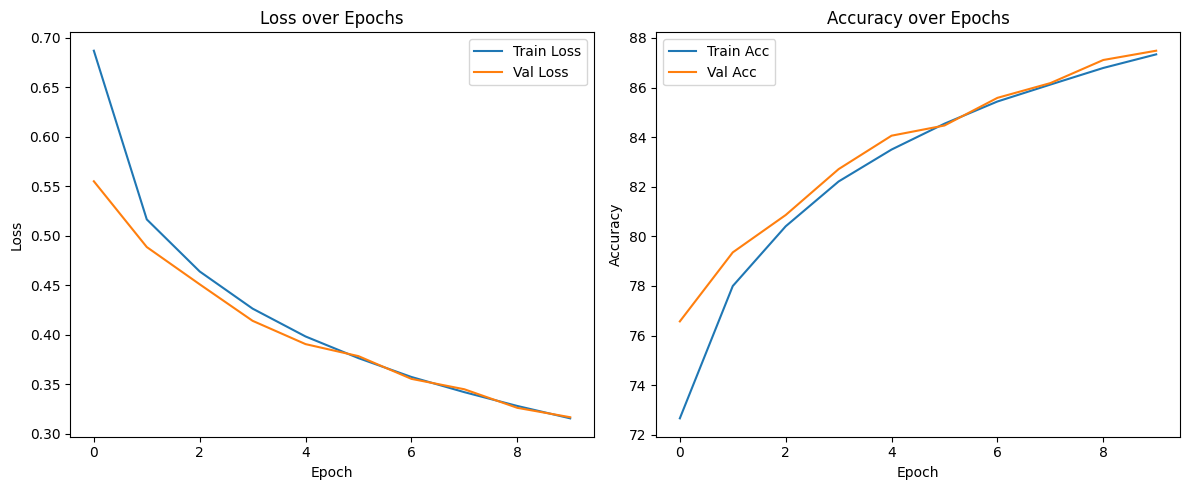

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
data = pd.read_csv(r'compressed_data.csv.gz')
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type'] - 1  # Adjust labels to be zero-indexed

# Preprocessing
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(1024)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024)

# Define model
class Net(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = layers.Dense(hidden_size, activation='relu')  # Use input_size here
        self.fc2 = layers.Dense(hidden_size // 2, activation='relu')
        self.fc3 = layers.Dense(hidden_size // 4, activation='relu')
        self.fc4 = layers.Dense(hidden_size // 8, activation='relu')
        self.fc5 = layers.Dense(output_size, activation='linear')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return self.fc5(x)

# Automatically set input_size based on the dataset
input_size = X_train.shape[1]  # Number of features after preprocessing
hidden_size = 1024
output_size = len(np.unique(y))
model = Net(input_size, hidden_size, output_size)

# Define loss and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    correct_train, total_train = 0, 0

    for inputs, labels in train_dataset:
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            loss = loss_fn(labels, outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_loss += loss.numpy()
        predictions = tf.argmax(outputs, axis=1)
        correct_train += tf.reduce_sum(tf.cast(predictions == labels, tf.int32)).numpy()
        total_train += labels.shape[0]

    train_losses.append(epoch_loss / len(train_dataset))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    val_loss = 0
    correct_val, total_val = 0, 0
    for inputs, labels in test_dataset:
        outputs = model(inputs, training=False)
        loss = loss_fn(labels, outputs)
        val_loss += loss.numpy()
        predictions = tf.argmax(outputs, axis=1)
        correct_val += tf.reduce_sum(tf.cast(predictions == labels, tf.int32)).numpy()
        total_val += labels.shape[0]

    val_losses.append(val_loss / len(test_dataset))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%')

# Final Evaluation
y_true, y_pred, y_prob = [], [], []
for inputs, labels in test_dataset:
    outputs = model(inputs, training=False)
    probs = tf.nn.softmax(outputs)
    preds = tf.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())
    y_prob.extend(probs.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
y_true_binarized = LabelBinarizer().fit_transform(y_true)
auc_score = roc_auc_score(y_true_binarized, y_prob, multi_class='ovr')

print(f"\nFinal Evaluation:")
print(f"Accuracy  = {accuracy*100:.2f}%")
print(f"Precision = {precision*100:.2f}%")
print(f"Recall    = {recall*100:.2f}%")
print(f"F1 Score  = {f1*100:.2f}%")
print(f"AUC-ROC   = {auc_score*100:.2f}%")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve (One vs Rest)
plt.figure(figsize=(10, 8))
for i in range(output_size):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    auc_i = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.tight_layout()
plt.show()

# Training History Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\muham\AppData\Local\Temp\ipykernel_22620\1168821852.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input_pt = torch.tensor(X_test[sample_idx], dtype=torch.float32).unsqueeze(0)  # shape: (1, features)



=== Sample Prediction (Index: 74615) ===
True Label           : 0
[PyTorch] Prediction : 0
[PyTorch] Probabilities: [9.9956483e-01 1.7913459e-04 2.0143399e-20 1.7691195e-26 5.5397848e-15
 8.3290386e-20 2.5607873e-04]
[TensorFlow] Prediction : 0
[TensorFlow] Probabilities: [9.9915922e-01 2.2645608e-04 2.4081051e-10 3.7502224e-12 3.0107157e-09
 7.5996232e-12 6.1442103e-04]


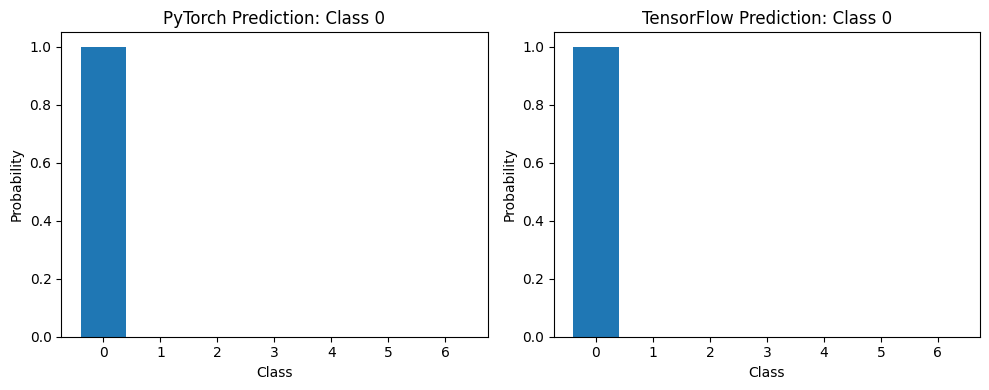

In [9]:
# === Combined Sample Prediction (PyTorch + TensorFlow) ===
import random

# Select one random sample index
sample_idx = random.randint(0, X_test.shape[0] - 1)

# ===== PyTorch Prediction =====
sample_input_pt = torch.tensor(X_test[sample_idx], dtype=torch.float32).unsqueeze(0)  # shape: (1, features)
model_pt.eval()
with torch.no_grad():
    sample_output_pt = model_pt(sample_input_pt)
    sample_probs_pt = torch.softmax(sample_output_pt, dim=1).squeeze()
    sample_pred_pt = torch.argmax(sample_probs_pt).item()

# ===== TensorFlow Prediction =====
sample_input_tf = X_test[sample_idx].reshape(1, -1)  # shape: (1, features)
sample_output_tf = model(sample_input_tf, training=False)
sample_probs_tf = tf.nn.softmax(sample_output_tf)
sample_pred_tf = tf.argmax(sample_probs_tf, axis=1).numpy()[0]

# ===== Ground Truth Label =====
true_label = y_test.values[sample_idx] if isinstance(y_test, pd.Series) else y_test[sample_idx]

# ===== Print Results =====
print(f"\n=== Sample Prediction (Index: {sample_idx}) ===")
print(f"True Label           : {true_label}")
print(f"[PyTorch] Prediction : {sample_pred_pt}")
print(f"[PyTorch] Probabilities: {sample_probs_pt.numpy()}")
print(f"[TensorFlow] Prediction : {sample_pred_tf}")
print(f"[TensorFlow] Probabilities: {sample_probs_tf.numpy().flatten()}")

# Visualization of Class Probabilities (Optional)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(sample_probs_pt)), sample_probs_pt.numpy())
plt.title(f"PyTorch Prediction: Class {sample_pred_pt}")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.bar(range(len(sample_probs_tf.numpy().flatten())), sample_probs_tf.numpy().flatten())
plt.title(f"TensorFlow Prediction: Class {sample_pred_tf}")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# ANALISIS HASIL DARI CLASSIFICATION

**Hasil dari PyTorch:**

- **Accuracy**: 87.42%
- **Precision**: 85.59%
- **Recall**: 74.89%
- **F1 Score**: 78.87%
- **AUC Score**: 98.67%

**Hasil dari Tensorflow:**

- **Accuracy**: 87.49%
- **Precision**: 82.27%
- **Recall**: 74.36%
- **F1 Score**: 77.45%
- **AUC Score**: 98.53%

**Hasil Prediction dari Sample:**

- **True Label**: 0
- **[PyTorch] Prediction**: 0
- **[PyTorch] Probabilities**: [9.9956483e-01 1.7913459e-04 2.0143399e-20 1.7691195e-26 5.5397848e-15 8.3290386e-20 2.5607873e-04]
- **[TensorFlow] Prediction**: 0
- **[TensorFlow] Probabilities**: [9.9915922e-01 2.2645608e-04 2.4081051e-10 3.7502224e-12 3.0107157e-09 7.5996232e-12 6.1442103e-04]

Skor AUC keduanya sangat tinggi, modelnya termasuk bagus untuk klasifikasi. Pada pengetesan dengan sample hasil keduanya sama untuk prediksi class-nya.

# ACCURACY, PRECISION, RECALL, F1 SCORE, DAN AUC SCORE

## Accuracy
Accuracy mengukur proporsi dari prediksi yang benar dari keseluruhan prediksi.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ TN $\): True Negative (Benar Negatif)
- \($ FP $\): False Positive (Salah Positif)
- \($ FN $\): False Negative (Salah Negatif)



## Precision
Precision mengukur proporsi dari prediksi positif yang benar dari keseluruhan prediksi positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ FP $\): False Positive (Salah Positif)



## Recall
Recall mengukur proporsi dari prediksi positif yang benar dari keseluruhan kasus positif sebenarnya.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ FN $\): False Negative (Salah Negatif)



## F1 Score
F1 Score adalah rata-rata harmonis dari Precision dan Recall. F1 Score memberikan keseimbangan antara Precision dan Recall.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$



## AUC Score
AUC (Area Under the Curve) Score adalah ukuran kinerja model klasifikasi. AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). AUC berkisar antara 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan kinerja model yang lebih baik.

$$
\text{AUC} = \int_{0}^{1} TPR(dFPR)
$$

**Keterangan:**
- \($ TPR $\): True Positive Rate (Tingkat Benar Positif)
- \($ FPR $\): False Positive Rate (Tingkat Salah Positif)


